<a href="https://colab.research.google.com/github/sachalapins/U-GPD/blob/main/1_UGPD_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training U-GPD Transfer Learning Model for Nabro Volcano

Last updated 28th Jul 2021.
___

The code in this notebook accompanies the JGR: Solid Earth paper **_"Lapins et al. (2021) A Little Data goes a Long Way: Automating Seismic Phase Arrival Picking at Nabro Volcano with Transfer Learning"_**, https://doi.org/10.1029/2021JB021910 (open access).

If you find the code, data or results in this notebook useful, please consider citing the paper or the dataset directly (https://doi.org/10.5281/zenodo.4498549).

This notebook has been developed and tested in Google Colab. A conda environment yml file (https://github.com/sachalapins/U-GPD/ugpd.yml) is provided for those who wish to download this notebook and run it locally but note that small changes may need to be made.

If you have any suggestions for improvements, issues running the code or notice any errors then please feel free to contact me ([sacha.lapins@bristol.ac.uk](mailto:sacha.lapins@bristol.ac.uk)).

Many thanks.

Sacha Lapins, University of Bristol
<br>



---

<br>   
In this notebook, we show how to produce and train our U-GPD transfer learning model (Fig 1), utilising pre-trained weights from the extensively-trained GPD model (Ross et al., 2018, BSSA, https://doi.org/10.1785/0120180080) within a U-Net architecture.

<br>

![](https://github.com/sachalapins/U-GPD/raw/main/figs/supp1.png)

**Figure.** U-GPD model architecture. Pre-trained feature extraction layers from GPD model are copied to new model to extract generalised signal features from inputted seismic waveform. These pre-trained weights are fine-tuned with new Nabro data and low learning rate to overcome optimisation difficulties from splitting co-adapted model layers without unlearning important generalised features. This feature extraction system is then fed into new convolutional layers (with upsampling and skip connections) to produce a prediction (P, S or noise) for each datapoint in our seismic waveform. These new layers are initiliased with randomised weights and are trained with a higher learning rate.




## 1. Load modules etc

First, make sure Hardware Accelerator is set to GPU (click on 'Runtime' menu at top, then 'Change runtime type', then make sure GPU is selected from drop down menu under 'Hardware accelerator').

Then, let's load required modules and define some functions.

In [1]:
# Original GPD model was produced using TensorFlow (TF) version 1, so we need to tell Google Colab to use v1 (comment out this step if using conda environment above)
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Version of h5py that comes pre-installed with Colab now doesn't like loading older keras models. Need to install earlier version before importing.
!pip install 'h5py<3.0.0'

     |████████████████████████████████| 2.9 MB 7.9 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [3]:
# Import modules
import string
import time
import argparse as ap
import sys
import os

import numpy as np
import pandas as pd

import math

import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras import losses
from keras.legacy import interfaces
from keras.callbacks import ModelCheckpoint

import h5py
import json

import random

import scipy.stats as stats
import scipy.signal as signal

Using TensorFlow backend.


In [4]:
# Adam optimiser with variable learning rates (applied through a learning rate multiplier)
# This allows you to set a learning rate 'multiplier' for different layers (so we can have lower learning rate for GPD layers)

# Adapted from: https://erikbrorson.github.io/2018/04/30/Adam-with-learning-rate-multipliers/


class Adam_lr_mult(Optimizer):
    """Adam optimizer.
    Adam optimizer, with learning rate multipliers built on Keras implementation
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        
    AUTHOR: Erik Brorson
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False,
                 multipliers=None, debug_verbose=False,**kwargs):
        super(Adam_lr_mult, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self._lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad
        self.multipliers = multipliers
        self.debug_verbose = debug_verbose

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self._lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):

            # Learning rate multipliers
            if self.multipliers:
                multiplier = [mult for mult in self.multipliers if mult in p.name]
            else:
                multiplier = None
            if multiplier:
                new_lr_t = lr_t * self.multipliers[multiplier[0]]
                if self.debug_verbose:
                    print('Setting {} to learning rate {}'.format(multiplier[0], new_lr_t))
                    print(K.get_value(new_lr_t))
            else:
                new_lr_t = lr_t
                if self.debug_verbose:
                    print('No change in learning rate {}'.format(p.name))
                    print(K.get_value(new_lr_t))
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - new_lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - new_lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self._lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad,
                  'multipliers':self.multipliers}
        base_config = super(Adam_lr_mult, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## 2. Set training hyperparameters

Next, let's set some training hyperparameters.

- `batch_size = 100`: This is the number of training examples used at each iteration to estimate error gradient and update model weights. There is generally some trial and error when setting this parameter and it can have quite a big effect on training time, generalisation and finding global optima. It is generally accepted there is some 'sweet spot' between 1 and the full dataset (helpful!), with lower values (e.g., 16 or 32) generally preferred. Some people recommend starting with a small batch size (to speed up convergence and training time) and increase it throughout model training (to get better convergence on global optima). I found a batch size of 100 to work well here but you may find you can improve results further by exploring this parameter.

- `epochs = 150`: This is no. of iterations through your full training set. If model hyperparameters and architecture are well-designed, and you have sufficient training data, the model should continue to improve (or plateau) with further training. In the paper we train our model for 300 epochs, but here we will just do it for 150 epochs as this takes just a few mins on a GPU and subsequent training curves (accuracy and loss) suggest there is relatively little gain from training further (see plot after model training). By all means feel free to play around with this parameter and train the model for shorter or longer!

- `use_box_labels = True`: The training/validation sets include labels with boxcar functions (binary 0 or 1 values) to label phase arrivals and also Gaussian-style labels (varying values between 0 and 1). This is a flag for which to use (True = boxcar labels, False = Gaussian-style labels). Feel free to try both but we will stick with binary boxcar labels here.

- `dropout_rate = 0.3`: Dropout is where you randomly set a proportion of parameters in a NN layer to zero during training (a value of 0.3 was found to be optimum during experimentation). It aids generalisation and promotes independence between the different features the model extracts as it can't become over-reliant on any particular one. The original GPD model doesn't use dropout and I didn't want to alter the GPD layers in any way, so I leave them as they are without dropout. By adding dropout to my new layers, however, the new model achieves better validation loss and accuracy and continues to improve for longer during training.


In [5]:
# Some training hyperparameters
batch_size = 100
epochs = 150 # To save time - in the paper we train for 300 epochs
use_box_labels = True
dropout_rate = 0.3

## 3. Load in original pre-trained GPD model

To copy the GPD layers we must first download the model from the original GitHub repo (https://github.com/interseismic/generalized-phase-detection).

In [6]:
# Clone GPD model GitHub repo:
!git clone https://github.com/interseismic/generalized-phase-detection.git

Cloning into 'generalized-phase-detection'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26
Unpacking objects: 100% (26/26), done.


In [7]:
# Paths to original GPD model, to store new model, to store training and validation data, and to store training results (training curves etc)
path_to_gpd_model = './generalized-phase-detection/'
path_to_new_model =  './new_model/'
path_to_train_val = './train_val/'
path_to_results = './training_results/'

# Make directories to store model and results:
if not os.path.exists(path_to_new_model):
    os.makedirs(path_to_new_model)
if not os.path.exists(path_to_train_val):
    os.makedirs(path_to_train_val)
if not os.path.exists(path_to_results):
    os.makedirs(path_to_results)

To use the feature extraction layers from the GPD model, we need to load the entire model and its pre-trained weights first:

In [8]:
# Load Ross et al 2018 json and create model
json_file = open(path_to_gpd_model + 'model_pol.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
gpd_model = model_from_json(loaded_model_json, custom_objects={'tf':tf})

# Load weights into new model
gpd_model.load_weights(path_to_gpd_model + "model_pol_best.hdf5")
print("*** ORIGINAL GSPD MODEL + WEIGHTS LOADED FROM DISK ***")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

*** ORIGINAL GSPD MODEL + WEIGHTS LOADED FROM DISK ***


## 4. Create new U-GPD model

The code block below creates the entire new U-GPD model that we will be training. If you are not interested in the details then you can ignore the rest of the text here...

<br>

### GPD Feature Extraction
The first two lines create the 'input' layer for the model.

The next 16 lines add the convolutional layers and other associated layers (batch normalization, ReLU activation and max pooling) from the pre-trained GPD model.

### New Layers
From `Deconv block 5` onwards, we create new layers with dropout, upsampling, dilated convolutions and reordering of ReLU activation and batch normalization.

The aim of these new layers is to upsample the data back towards the input dimensions (400 x 3) through a process known as 'deconvolution'. 

### Deconovlution
In CNNs, deconvolution is simply upsampling then convolution (the reverse operation of convolution then downsampling/pooling). It is called deconvolution as it is a way of reversing the convolutional steps in, say, an autoencoder (see https://github.com/keras-team/keras/issues/2822 for further discussion). As the convolutional kernels start as random values, and these are all learned by the model, there would be no actual difference between a convolution and deconvolution operation (I believe), i.e., initiating deconvolution kernels with random weights is the same as initiating convolution kernels with random weights.

### Dilated Convolution
We also use dilated convolution (with increasing dilation rate) in the new layers (e.g., Fig 3 of https://arxiv.org/pdf/1609.03499.pdf). Using dilated convolution gives the model a wider field of view, so provides the model with more temporal information from across our waveform to isolate phase arrivals. The dilation rate indicates how dilated the filter kernels in this layer should be and is intuitively based on the way wavelets are dilated to characterise different scales in wavelet transforms.

### Spatial Dropout
In standard dense neural networks (fully connected nodes, no convolution), dropout sets a proportion of the connection weights at random to zero. Setting random weights (which are values within your filter kernel) to zero in convolutional layers is not useful. So, instead, dropout in convolutional layers is applied by dropping entire features. This is known as spatial dropout to differentiate from normal dropout.

### ReLU then Batch Normalisation
We reverse the order of ReLU activation and batch normalisation (i.e., activation before batch norm, as opposed to batch norm then activation in the GPD layers). This isn't because we are now doing the reverse of the downward GPD feature extraction path. People generally see improved performance if they do activation before batch norm, and I did too.

### Skip connections
Skip connections simply combine the part in the 'downsampling' GPD path that matches the dimensions of the part in our new 'upsampling' path at each stage. More commonly, these are concatenated together (along the channels axis) rather than added (summed) together as concatenation generally shows improved performance. However, this would give us more channels to convolve (and therefore more model parameters / kernels to train) at each layer. As we are working with limited amounts of training data, using addition instead of concatenation appears to show better results and be intuitively more appropriate in terms of number of new model parameters to train.

In [9]:
input_size = (400, 3) # Waveform input dimensions (400 samples, 3 channels)
inputs = Input(input_size, name="input_layer") # Input layer

#### GSPD LAYERS (TO BE FINE-TUNED) ####
# Conv block 1
conv1 = gpd_model.layers[4].layers[0](inputs) # Conv1D: output 400 x 32
conv1 = gpd_model.layers[4].layers[1](conv1) # Batch Norm.
conv1 = gpd_model.layers[4].layers[2](conv1) # ReLU activation
pool1 = gpd_model.layers[4].layers[3](conv1) # MaxPooling: output 200 x 32

# Conv block 2
conv2 = gpd_model.layers[4].layers[4](pool1) # Conv1D: output 200 x 64
conv2 = gpd_model.layers[4].layers[5](conv2) # Batch Norm.
conv2 = gpd_model.layers[4].layers[6](conv2) # ReLU
pool2 = gpd_model.layers[4].layers[7](conv2) # MaxPooling: output 100 x 64

# Conv block 3
conv3 = gpd_model.layers[4].layers[8](pool2) # Conv1D: output 100 x 128
conv3 = gpd_model.layers[4].layers[9](conv3) # Batch Norm.
conv3 = gpd_model.layers[4].layers[10](conv3) # ReLU
pool3 = gpd_model.layers[4].layers[11](conv3) # MaxPooling: output 50 x 128

# Conv block 4
conv4 = gpd_model.layers[4].layers[12](pool3) # Conv1D: output 50 x 256
conv4 = gpd_model.layers[4].layers[13](conv4) # Batch Norm.
conv4 = gpd_model.layers[4].layers[14](conv4) # ReLU
pool4 = gpd_model.layers[4].layers[15](conv4) # MaxPooling: output 25 x 256
####

#### NEW MODEL LAYERS (TO BE TRAINED FROM SCRATCH) ####
# Deconv block 5
up5_dil_rate = 1 # Dilation rate for dilated convolutions in this layer
up5 = SpatialDropout1D(rate=dropout_rate, name="up_5_dropout")(pool4) # Use dropout before Conv layer (https://arxiv.org/pdf/1904.03392.pdf)
# Then apply deconvolution (upsample and Conv1D; e.g., https://github.com/keras-team/keras/issues/2822)
up5 = UpSampling1D(size = 2, name="up_5_upsample")(up5) # Upsample
up5 = Conv1D(128, 5, dilation_rate = up5_dil_rate, activation = None, padding = 'same', kernel_initializer = 'glorot_uniform', name="up_5_conv")(up5) # Conv1D - output 50 x 128
up5 = Activation("relu", name="up_5_relu")(up5) # ReLU
up5 = BatchNormalization(name="up_5_batch")(up5) # Batch Norm. *AFTER* activation now
# Skip connection:
merge5 = Add(name="merge_5")([pool3, up5]) # Add output of conv block 3 to output of deconv block 5

# Deconv block 6
up6_dil_rate = 3 # Dilation rate for dilated convolutions in this layer
up6 = SpatialDropout1D(rate=dropout_rate, name="up_6_dropout")(merge5) # Dropout
up6 = UpSampling1D(size = 2, name="up_6_upsample")(up6) # Upsample
up6 = Conv1D(64, 7, dilation_rate = up6_dil_rate, activation = None, padding = 'same', kernel_initializer = 'glorot_uniform', name="up_6_conv")(up6) # Conv1D - output 100 x 64
up6 = Activation("relu", name="up_6_relu")(up6) # ReLU
up6 = BatchNormalization(name="up_6_batch")(up6) # Batch Norm.
# Skip connection:
merge6 = Add(name="merge_6")([pool2, up6]) # Add output of conv block 2 to output of deconv block 6

# Deconv block 7
up7_dil_rate = 9 # Dilation rate for this layer
up7 = SpatialDropout1D(rate=dropout_rate, name="up_7_dropout")(merge6) # Dropout
up7 = UpSampling1D(size = 2, name="up_7_upsample")(up7) # Upsample
up7 = Conv1D(32, 9, dilation_rate = up7_dil_rate, activation = None, padding = 'same', kernel_initializer = 'glorot_uniform', name="up_7_conv")(up7) # Conv1D - output 200 x 32
up7 = Activation("relu", name="up_7_relu")(up7) # ReLU
up7 = BatchNormalization(name="up_7_batch")(up7) # Batch Norm.
# Skip connection:
merge7 = Add(name="merge_7")([pool1, up7]) # Add output of conv block 1 to output of deconv block 7

# Deconv block 8
up8 = SpatialDropout1D(rate=dropout_rate, name="up_8_dropout")(merge7) # Dropout
up8 = UpSampling1D(size = 2, name="up_8_upsample")(up8) # Upsample
up8 = Conv1D(32, 11, activation = None, padding = 'same', kernel_initializer = 'glorot_uniform', name="up_8_conv")(up8) # Conv1D - output 400 x 32
up8 = Activation("relu", name="up_8_relu")(up8) # ReLU
up8 = BatchNormalization(name="up_8_batch")(up8) # Batch Norm.

merge8 = SpatialDropout1D(rate=dropout_rate)(up8) # Dropout

# Model Output Layer
outputs = Conv1D(3, 1, activation = 'softmax', name="main_output")(up8) # Conv1D - output 400 x 3

### Create new model ###
model = Model(inputs = inputs, outputs = outputs)

#### Save untrained U-GPD model (e.g., for reinitialising weights and training model from scratch later) ####
model.save(path_to_new_model + 'model_untrained.h5')

If we compare our new model architecture with the original GPD architecture, we can see that using convolutional layers in place of the original fully-connected layers greatly reduces the number of trainable parameters (most of which are also being fine-tuned from the original GPD model).

In [10]:
# New model architecture:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 400, 3)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 400, 32)      2048        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 400, 32)      128         conv1d_1[1][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 400, 32)      0           batch_normalization_1[1][0]      
____________________________________________________________________________________________

In [11]:
# GPD model architecture
gpd_model.layers[4].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 400, 32)           2048      
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 400, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 64)           30784     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 64)           256       
_________________________________________________________________
activation_2 (Activation)    (None, 200, 64)          

The next step is to set different learning rates for the pre-trained and new parts of the model. After, we compile the model and it is ready for training.

In [12]:
# Set different learning rates for GPD and new parts of the model:

learning_rate = 1e-3 # Learning Rate for new layers

learning_rate_multipliers = {} # To store which layers should have different LR
# Get names of GPD layers and add learning rate multiplier:
for l in np.arange(1, 17):
    if l < 9:
        learning_rate_multipliers[model.layers[l].name] = 0.001 # First two conv layers from original GPD model should now have LR = 1e-6 (most generalised features)
    else:
        learning_rate_multipliers[model.layers[l].name] = 0.01 # Remaining conv layers of original GPD layers should now have LR = 1e-5

# Create Adam optimizer using these different learning rates
adam_with_lr_multipliers = Adam_lr_mult(lr=learning_rate, multipliers=learning_rate_multipliers) # Optimizer

# Compile model
if use_box_labels:
    model.compile(optimizer = adam_with_lr_multipliers, loss = "categorical_crossentropy", metrics = ['accuracy'])
else:
    model.compile(optimizer = adam_with_lr_multipliers, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])

## 5. Download training data

The last step before training is to load the training data. This is archived on Zenodo at https://doi.org/10.5281/zenodo.4498549.

In [13]:
#### INSTALL ZENODO_GET TO GET DATA FROM ZENODO ####
!pip install zenodo-get

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=6f6c0733efa65df1e952569135e070ce575281109a47478d8fa1cc77b2cedb86
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [14]:
#### DOWNLOAD TRAINING AND VALIDATION DATA ####
# List download paths for training/val data:
!zenodo_get -d 10.5281/zenodo.4498549 -w ./train_val/urls.txt

# Download data to train_val directory:
!wget -i ./train_val/urls.txt -P ./train_val/

--2021-07-28 15:49:32--  https://zenodo.org/record/4498549/files/df_train_events_2498.pkl
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88332 (86K) [application/octet-stream]
Saving to: ‘./train_val/df_train_events_2498.pkl’

df_train_events_249 100%[===================>]  86.26K   276KB/s    in 0.3s    

2021-07-28 15:49:33 (276 KB/s) - ‘./train_val/df_train_events_2498.pkl’ saved [88332/88332]

--2021-07-28 15:49:33--  https://zenodo.org/record/4498549/files/df_train_noise_2498.pkl
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 45856 (45K) [application/octet-stream]
Saving to: ‘./train_val/df_train_noise_2498.pkl’

df_train_noise_2498 100%[===================>]  44.78K   287KB/s    in 0.2s    

2021-07-28 15:49:34 (287 KB/s) - ‘./train_val/df_train_noise_2498.pkl’ saved [45856/45856]

--2021-07-28 15:

In [15]:
#### READ DOWNLOADED DATA ####

# Load in event metadata (UTC times for P-/S-wave arrivals)
df_train = pd.read_pickle(path_to_train_val + 'df_train_events_2498.pkl') # All (2498) training examples
df_val = pd.read_pickle(path_to_train_val + 'df_val_events.pkl') # Validation (423 examples)

# Load in training waveforms
train_hf = h5py.File(path_to_train_val + 'train_events_2498.h5', 'r') # All training examples
train_x = train_hf.get('x') # Waveforms
train_x = np.array(train_x)
train_yp = train_hf.get('yp') # Gaussian style probability mask
train_yp = np.array(train_yp)
train_yb = train_hf.get('yb') # Box function mask
train_yb = np.array(train_yb).astype(int)
train_hf.close()

# Decimate training data to 50 Hz
train_x_dec = signal.decimate(train_x, q=2, ftype="fir", axis=1, zero_phase=True)
train_yp_dec = train_yp[:,np.arange(0, train_yp.shape[1], 2),:]
train_yb_dec = train_yb[:,np.arange(0, train_yb.shape[1], 2),:]

# Load in validation waveforms
val_hf = h5py.File(path_to_train_val + 'val_events.h5', 'r') # Validation (250 examples)
val_x = val_hf.get('x') # Waveforms
val_x = np.array(val_x)
val_yp = val_hf.get('yp') # Gaussian style probability mask
val_yp = np.array(val_yp)
val_yb = val_hf.get('yb') # Box function mask
val_yb = np.array(val_yb).astype(int)
val_hf.close()

# Decimate validation data to 50 Hz
val_x_dec = signal.decimate(val_x, q=2, ftype="fir", axis=1, zero_phase=True)
val_yp_dec = val_yp[:,np.arange(0, val_yp.shape[1], 2),:]
val_yb_dec = val_yb[:,np.arange(0, val_yb.shape[1], 2),:]

# Load in noise metadata (UTC times for middle of noise window)
df_train_n = pd.read_pickle(path_to_train_val + 'df_train_noise_2498.pkl') # All (2498) training examples
df_val_n = pd.read_pickle(path_to_train_val + 'df_val_noise.pkl') # Validation (423 examples)

train_n_hf = h5py.File(path_to_train_val + 'train_noise_2498.h5', 'r') # All training examples
train_x_n = train_n_hf.get('x') # Wavforms
train_x_n = np.array(train_x_n)
train_y_n = train_n_hf.get('y') # Noise labels - all 1's on the noise channel and 0's on the P and S channels
train_y_n = np.array(train_y_n)
train_n_hf.close()

val_n_hf = h5py.File(path_to_train_val + 'val_noise.h5', 'r') # All validation examples
val_x_n = val_n_hf.get('x') # Waveforms
val_x_n = np.array(val_x_n)
val_y_n = val_n_hf.get('y') # Noise labels - all 1's on the noise channel and 0's on the P and S channels
val_y_n = np.array(val_y_n)
val_n_hf.close()

# Decimate noise data to 50 Hz
train_x_n_dec = signal.decimate(train_x_n, q=2, ftype="fir", axis=1, zero_phase=True)
train_y_n_dec = train_y_n[:,np.arange(0, train_y_n.shape[1], 2),:]
val_x_n_dec = signal.decimate(val_x_n, q=2, ftype="fir", axis=1, zero_phase=True)
val_y_n_dec = val_y_n[:,np.arange(0, val_y_n.shape[1], 2),:]

print("*** TRAINING DATA LOADED ***")

*** TRAINING DATA LOADED ***


Let's just quickly explore and plot some of the training/validation data.

In [16]:
# Training waveforms dimensions
train_x.shape

(2498, 2800, 3)

Our training set dimensions are 2498 x 2800 x 3: we have 2498 waveforms with 2800 samples (@ 100 samples per second = 28 seconds in length) and 3 channels (E, N, Z).

We've created a training set with much longer waveforms (28 secs) than the input size to this model (4 secs) so that we can augment the training set throughout training by time-shifting around the P and S arrivals. The max S-P time difference in our training set is 12 secs so 28 seconds encompasses both P and S arrivals in all our training examples (with some room at each end for decimating, filtering, etc).

In the training loop a bit further down, we randomly select to train using the P or S arrival as the focus of that waveform (with probability of 0.5).

Let's look at the first training waveform:

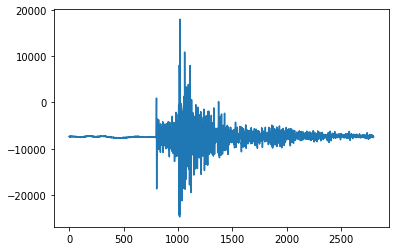

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.plot(train_x[0,:,2]) # Just vertical component (index 0 on final axis is E, index 1 is N and index 2 is Z)
plt.show()

All P arrivals are located 800 samples in, and S-wave location can be determined by S-P difference from the `df_train` dataframe.

e.g.,

In [18]:
p_index = 800 # Location of P-wave arrival in samples
fs = 100 # Sample frequency = 100 Hz
s_index = round((df_train.s_time[0] - df_train.p_time[0]).total_seconds() * fs) + p_index # Location of S-wave arrival
s_index

1010

The corresponding labels look like this:

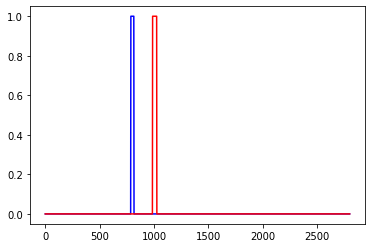

In [19]:
# Boxcar labels
plt.plot(train_yb[0,:,0], 'b') # P-wave probability (blue)
plt.plot(train_yb[0,:,1], 'r') # S-wave probability (red)
#plt.plot(train_yb[0,:,2], 'g') # Noise probability (green) - this is just 1 minus the above two traces
plt.show()

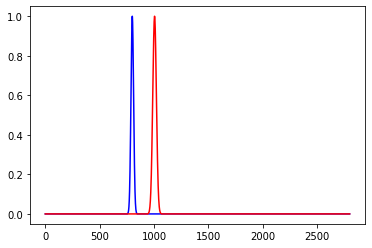

In [20]:
# Gaussian-style labels
plt.plot(train_yp[0,:,0], 'b') # P-wave probability (blue)
plt.plot(train_yp[0,:,1], 'r') # S-wave probability (red)
#plt.plot(train_yp[0,:,2], 'g') # Noise probability (green) - this is just 1 minus the above two traces
plt.show()

## 6. Train U-GPD transfer learning model

Below is the actual model training loop.

Briefly, for each epoch, we first choose either the P- or S- wave for each event waveform with probability 0.5.

We then window the chosen arrival so that it is randomly time-shifted somewhere within 100 samples either side of the centre of the window (which is 400 samples in length, so the arrival is somewhere between index 100 and 300 of the window).

We do this for both training and validation event waveforms.

For sections of noise, our training set has 20-secs sections of noise containing no phase arrivals (all manually QC'd). We then simply randomly select a 400 sample (4 sec) section of these longer sections at each training epoch, that way noise training data are never exactly the same between epochs.

**Training will take 10-15 mins**. 300 epochs is probably more than you need but still useful to see what happens as you continue to train the model.

In [21]:
# Training loop
for e in np.arange(0, epochs):
    print("Epoch " + str(e+1) + " of " + str(epochs))
    
    #### Generate time-shifted data ####
    # Pick P or S arrival as 'focus' (if < 0.5 then use P, else use S)
    p_or_s_train = np.random.uniform(size=train_x.shape[0]) # For training data
    train_diff = (df_train['s_time']-df_train['p_time']).reset_index(drop=True) # P-S time difference
    p_or_s_val = np.random.uniform(size=val_x.shape[0]) # For validation data
    val_diff = (df_val['s_time']-df_val['p_time']).reset_index(drop=True) # P-S time difference
    
    # Create arrays to accomodate shifted windows and labels - all zeros initially, now 4 secs (400 samples) in length
    train_x_copy = np.zeros([train_x.shape[0] * 2, 400, 3])
    val_x_copy = np.zeros([val_x.shape[0] * 2, 400, 3])
    if use_box_labels:
        train_y_copy = np.zeros([train_yb.shape[0] * 2, 400, 3])
        val_y_copy = np.zeros([val_yb.shape[0] * 2, 400, 3])
    else:
        train_y_copy = np.zeros([train_yp.shape[0] * 2, 400, 3])
        val_y_copy = np.zeros([val_yp.shape[0] * 2, 400, 3])

    # Decimate signal? - Flag 0 or 1
    decimate_train = np.rint(np.random.uniform(size=train_x_copy.shape[0])) # 0 = 100 Hz or 1 = 50 Hz
    decimate_val = np.rint(np.random.uniform(size=val_x_copy.shape[0])) # 0 = 100 Hz or 1 = 50 Hz
    
    # Generate random shifts for each window of training data - do phase arrivals first
    for i in np.arange(0, train_x.shape[0]):
        # Take 4 sec window
        if decimate_train[i] == 0: # Keep as 100 Hz
            if p_or_s_train[i] < 0.5:
                shift_by = random.choices(np.arange(500, 700), k=1) # P-picks are located at 800 samples in, so this puts P between 100 and 300 samples in
            else:
                s_index = round(train_diff[i].total_seconds()*100) + 800
                shift_by = random.choices(np.arange(s_index - 300, s_index - 100), k=1) # This puts S pick between 100 and 300 samples in
                
            train_x_copy[i, :, :] = train_x[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            if use_box_labels:
                train_y_copy[i, :, :] = train_yb[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard boxcar prob function
            else:
                train_y_copy[i, :, :] = train_yp[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard gauss prob function
        # Else use 50 Hz decimated data
        else:
            if p_or_s_train[i] < 0.5:
                shift_by = random.choices(np.arange(100, 300), k=1) # P-picks are now located at 400 samples in, so this puts P 100-300 samples into window
            else:
                s_index = round(train_diff[i].total_seconds()*50) + 400
                shift_by = random.choices(np.arange(s_index - 300, s_index - 100), k=1) # This puts S pick between 100 and 300 samples in
            # Use decimated signals and labels
            train_x_copy[i, :, :] = train_x_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            if use_box_labels:
                train_y_copy[i, :, :] = train_yb_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard boxcar prob function
            else:
                train_y_copy[i, :, :] = train_yp_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard gauss prob function

    # Same for validation data
    for i in np.arange(0, val_x.shape[0]):
        if decimate_val[i] == 0: # Keep as 100 Hz
            if p_or_s_val[i] < 0.5:
                shift_by = random.choices(np.arange(500, 700), k=1) # P pick at index 800, so will be 100-300 samples in
            else:
                s_index = round(val_diff[i].total_seconds()*100) + 800
                shift_by = random.choices(np.arange(s_index - 300, s_index - 100), k=1)
                
            val_x_copy[i, :, :] = val_x[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            if use_box_labels:
                val_y_copy[i, :, :] = val_yb[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard box prob function
            else:
                val_y_copy[i, :, :] = val_yp[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard gauss prob function
        else:
            if p_or_s_val[i] < 0.5:
                shift_by = random.choices(np.arange(100, 300), k=1) # P pick now at index 400, so will be 100-300 samples in
            else:
                s_index = round(val_diff[i].total_seconds()*50) + 400
                shift_by = random.choices(np.arange(s_index - 300, s_index - 100), k=1) # S pick will be 100-300 samples in
            # Used decimated signals and labels    
            val_x_copy[i, :, :] = val_x_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            if use_box_labels:
                val_y_copy[i, :, :] = val_yb_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard box prob function
            else:
                val_y_copy[i, :, :] = val_yp_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard gauss prob function
                
    # Then noise:
    for i in np.arange(train_x.shape[0], train_x.shape[0] * 2):
        # Take 4 sec window
        which_noise = i - train_x.shape[0]
        if decimate_train[i] == 0: # Keep as 100 Hz
            shift_by = random.choices(np.arange(0, 1600), k=1) # Anywhere in 2000 sample window of noise
            train_x_copy[i, :, :] = train_x_n[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            train_y_copy[i, :, :] = train_y_n[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
        else:
            shift_by = random.choices(np.arange(100, 500), k=1) # Cut off first and last 100 samples of decimated signal window (now 1000 samples long) in case of edge effect
            train_x_copy[i, :, :] = train_x_n_dec[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            train_y_copy[i, :, :] = train_y_n_dec[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
                
    for i in np.arange(val_x.shape[0], val_x.shape[0] * 2):
        # Take 4 sec window
        which_noise = i - val_x.shape[0]
        if decimate_val[i] == 0: # Keep as 100 Hz
            shift_by = random.choices(np.arange(0, 1600), k=1) # Anywhere in 2000 sample window of noise
            val_x_copy[i, :, :] = val_x_n[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            val_y_copy[i, :, :] = val_y_n[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
        else:
            shift_by = random.choices(np.arange(100, 500), k=1) # Cut off first and last 100 samples of decimated signal window (now 1000 samples long) in case of edge effect
            val_x_copy[i, :, :] = val_x_n_dec[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            val_y_copy[i, :, :] = val_y_n_dec[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]


    # Remove trend + mean
    train_x_copy = signal.detrend(train_x_copy, axis=1)
    val_x_copy = signal.detrend(val_x_copy, axis=1)

    # Normalise across three components for each 3-channel 400-sample waveform
    train_x_copy = train_x_copy / np.max(np.abs(train_x_copy), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each window)
    val_x_copy = val_x_copy / np.max(np.abs(val_x_copy), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each window)

    # Now that we've produced our time-shifted data for this particular epoch, we can train
    
    #### THIS IS WHERE WE ACTUALLY TRAIN THE MODEL ####
    if e == 0:
        # This line is used to save model weights after each epoch (so we can use the best ones later)
        if use_box_labels:
            callback_list = [ModelCheckpoint(path_to_new_model + 'e' + str(e+1) + '_box.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)]
        else:
            callback_list = [ModelCheckpoint(path_to_new_model + 'e' + str(e+1) + '_gauss.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)]

        # Fit model (i.e. tune weights) to training data and check against validation data
        # Save results (loss and accuracy) to history
        history = model.fit(x=train_x_copy, y=train_y_copy,
                            validation_data=(val_x_copy, val_y_copy),
                            batch_size=batch_size,
                            epochs=1,
                            verbose=1,
                            callbacks=callback_list)
    else:
        if use_box_labels:
            callback_list = [ModelCheckpoint(path_to_new_model + 'e' + str(e+1) + '_box.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)]
        else:
            callback_list = [ModelCheckpoint(path_to_new_model + 'e' + str(e+1) + '_gauss.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)]
        
        # Fit model (i.e. tune weights) to training data and check against validation data
        # Save results (loss and accuracy) to new_history, then append these results to history
        new_history = model.fit(x=train_x_copy, y=train_y_copy,
                                validation_data=(val_x_copy, val_y_copy),
                                batch_size=batch_size,
                                epochs=1,
                                verbose=1,
                                callbacks=callback_list)

        # Append new loss and accuracy values to history
        if use_box_labels:
            history.history['val_loss'].append(new_history.history['val_loss'][0])
            history.history['val_accuracy'].append(new_history.history['val_accuracy'][0])
            history.history['loss'].append(new_history.history['loss'][0])
            history.history['accuracy'].append(new_history.history['accuracy'][0])
        else:
            history.history['val_loss'].append(new_history.history['val_loss'][0])
            history.history['val_categorical_accuracy'].append(new_history.history['val_categorical_accuracy'][0])
            history.history['loss'].append(new_history.history['loss'][0])
            history.history['categorical_accuracy'].append(new_history.history['categorical_accuracy'][0])

# When model training is finished, save the model
if use_box_labels:
    model.save(path_to_new_model + 'model_box.h5')
else:
    model.save(path_to_new_model + 'model_gauss.h5')

# Save learning history (accuracy and loss curves) to pkl file
if use_box_labels:
    history_df = pd.DataFrame(data = {'acc': history.history['accuracy'], 
                                        'loss': history.history['loss'], 
                                        'val_acc': history.history['val_accuracy'],
                                        'val_loss': history.history['val_loss']}
                                )
    history_df.to_pickle(path_to_results + 'history_box.pkl')
else:
    history_df = pd.DataFrame(data = {'acc': history.history['categorical_accuracy'], 
                                        'loss': history.history['loss'], 
                                        'val_acc': history.history['val_categorical_accuracy'],
                                        'val_loss': history.history['val_loss']}
                                )
    history_df.to_pickle(path_to_results + 'history_gauss.pkl')

print("*** TRAINING DONE ***")

Epoch 1 of 150
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 4996 samples, validate on 846 samples
Epoch 1/1
4996/4996 [==============================] - 14s 3ms/step - loss: 0.9593 - accuracy: 0.6616 - val_loss: 0.5662 - val_accuracy: 0.9337

Epoch 00001: saving model to ./new_model/e1_box.hdf5
Epoch 2 of 150
Train on 4996 samples, validate on 846 samples
Epoch 1/1
4996/4996 [==============================] - 2s 377us/step - loss: 0.4938 - accuracy: 0.9535 - val_loss: 0.2195 - val_accuracy: 0.9708

Epoch 00001: saving model to ./new_model/e2_box.hdf5
Epoch 3 of 150
Train on 4996 samples, validate on 846 samples
Epoch 1/1
4996/4996 [==============================] - 2s 369us/step - loss: 0.2572 - accuracy: 0.9728 - val_loss: 0.1512 - val_accuracy: 0.9717

Epoch 00001: saving model to ./new_model/e3_box.hdf5
Epoch 4 of 150
Train on 4996 samples, validate on 846 samples
Epoch 1/1
4996/4996 [==============================] - 2s 360

## 7. View training results

Let's plot how model loss evolved throughout model training.

In [22]:
# Dataframe with model accuracy and loss at the end of each training epoch for training and validation data:
history_df

,acc,loss,val_acc,val_loss
0,0.661628,0.959309,0.933694,0.566228
1,0.953497,0.493763,0.970824,0.219494
2,0.972813,0.257161,0.971702,0.151243
3,0.975202,0.160947,0.974441,0.111356
4,0.975930,0.121350,0.974338,0.091159
...,...,...,...,...
145,0.986314,0.035645,0.985301,0.037461
146,0.985892,0.036593,0.985816,0.036718
147,0.985961,0.036091,0.985851,0.036197
148,0.986185,0.036364,0.985990,0.036474


In [23]:
min(history_df['val_loss'])

0.034948909414470326

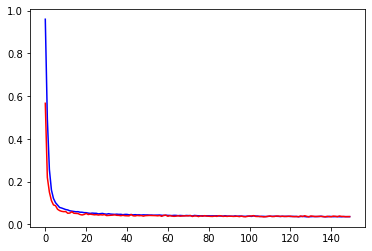

In [24]:
# Let's look at loss, as that is generally a more robust measure of model performance
plt.plot(history_df['loss'], 'b') # Model loss on training data (blue)
plt.plot(history_df['val_loss'], 'r') # Model loss on validation data (red)
plt.show()

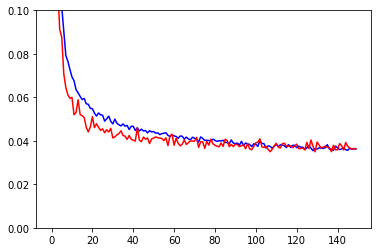

In [25]:
# Hard to see anything there as most of the detail is below 0.1 on y-axis.
# Let's change limits

plt.plot(history_df['loss'], 'b') # Model loss on training data (blue)
plt.plot(history_df['val_loss'], 'r') # Model loss on validation data (red)
plt.ylim(0, 0.1)
plt.show()

## 8. Compare with training model from scratch

Let's repeat the above steps, but reinitialise the pre-trained GPD model weights with randomised values (i.e., remove transfer learning).

In [26]:
# Load untrained U-GPD model
scratch_model = load_model(path_to_new_model + 'model_untrained.h5')

# Set all learning rates to be equal (i.e., 1e-3)
learning_rate = 1e-3 # Learning Rate for new layers

learning_rate_multipliers = {} # No layers should have learning rate multiplier

# Create Adam optimizer using equal learning rates
adam_with_lr_multipliers_scratch = Adam_lr_mult(lr=learning_rate, multipliers=learning_rate_multipliers) # Optimizer

# Compile new model
if use_box_labels:
    scratch_model.compile(optimizer = adam_with_lr_multipliers_scratch, loss = "categorical_crossentropy", metrics = ['accuracy'])
else:
    scratch_model.compile(optimizer = adam_with_lr_multipliers_scratch, loss = "categorical_crossentropy", metrics = ['categorical_accuracy'])

/tensorflow-1.15.2/python3.7/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [27]:
# Define function to reset all weights for a given layer
def reset_weights_layer(layer):
    session = K.get_session()
    if hasattr(layer, 'kernel_initializer'): 
        layer.kernel.initializer.run(session=session)
    if hasattr(layer, 'bias_initializer'):
        layer.bias.initializer.run(session=session)

# Reinitialise layers 1-16 as these are GPD layers (layer 0 is input)
for l in np.arange(1, 17):
    reset_weights_layer(scratch_model.layers[l])
print("*** WEIGHTS FROM GPD PART OF MODEL REINITIALISED TO RANDOM VALUES ***")

*** WEIGHTS FROM GPD PART OF MODEL REINITIALISED TO RANDOM VALUES ***


`scratch_model` should now have the same initial randomised weights as the transfer learning model's new layers, but with pre-trained GPD feature extraction weights also randomised.

Let's train it in the same way we train our transfer learning model and compare results.

In [28]:
# Training loop
for e in np.arange(0, epochs):
    print("Epoch " + str(e+1) + " of " + str(epochs))
    
    #### Generate time-shifted data ####
    # Pick P or S arrival as 'focus' (if < 0.5 then use P, else use S)
    p_or_s_train = np.random.uniform(size=train_x.shape[0]) # For training data
    train_diff = (df_train['s_time']-df_train['p_time']).reset_index(drop=True) # P-S time difference
    p_or_s_val = np.random.uniform(size=val_x.shape[0]) # For validation data
    val_diff = (df_val['s_time']-df_val['p_time']).reset_index(drop=True) # P-S time difference
    
    # Create arrays to accomodate shifted windows and labels - all zeros initially, now 4 secs (400 samples) in length
    train_x_copy = np.zeros([train_x.shape[0] * 2, 400, 3])
    val_x_copy = np.zeros([val_x.shape[0] * 2, 400, 3])
    if use_box_labels:
        train_y_copy = np.zeros([train_yb.shape[0] * 2, 400, 3])
        val_y_copy = np.zeros([val_yb.shape[0] * 2, 400, 3])
    else:
        train_y_copy = np.zeros([train_yp.shape[0] * 2, 400, 3])
        val_y_copy = np.zeros([val_yp.shape[0] * 2, 400, 3])

    # Decimate signal? - Flag 0 or 1
    decimate_train = np.rint(np.random.uniform(size=train_x_copy.shape[0])) # 0 = 100 Hz or 1 = 50 Hz
    decimate_val = np.rint(np.random.uniform(size=val_x_copy.shape[0])) # 0 = 100 Hz or 1 = 50 Hz
    
    # Generate random shifts for each window of training data - do phase arrivals first
    for i in np.arange(0, train_x.shape[0]):
        # Take 4 sec window
        if decimate_train[i] == 0: # Keep as 100 Hz
            if p_or_s_train[i] < 0.5:
                shift_by = random.choices(np.arange(500, 700), k=1) # P-picks are located at 800 samples in, so this puts P between 100 and 300 samples in
            else:
                s_index = round(train_diff[i].total_seconds()*100) + 800
                shift_by = random.choices(np.arange(s_index - 300, s_index - 100), k=1) # This puts S pick between 100 and 300 samples in
                
            train_x_copy[i, :, :] = train_x[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            if use_box_labels:
                train_y_copy[i, :, :] = train_yb[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard boxcar prob function
            else:
                train_y_copy[i, :, :] = train_yp[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard gauss prob function
        # Else use 50 Hz decimated data
        else:
            if p_or_s_train[i] < 0.5:
                shift_by = random.choices(np.arange(100, 300), k=1) # P-picks are now located at 400 samples in, so this puts P 100-300 samples into window
            else:
                s_index = round(train_diff[i].total_seconds()*50) + 400
                shift_by = random.choices(np.arange(s_index - 300, s_index - 100), k=1) # This puts S pick between 100 and 300 samples in
            # Use decimated signals and labels
            train_x_copy[i, :, :] = train_x_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            if use_box_labels:
                train_y_copy[i, :, :] = train_yb_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard boxcar prob function
            else:
                train_y_copy[i, :, :] = train_yp_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard gauss prob function

    # Same for validation data
    for i in np.arange(0, val_x.shape[0]):
        if decimate_val[i] == 0: # Keep as 100 Hz
            if p_or_s_val[i] < 0.5:
                shift_by = random.choices(np.arange(500, 700), k=1) # P pick at index 800, so will be 100-300 samples in
            else:
                s_index = round(val_diff[i].total_seconds()*100) + 800
                shift_by = random.choices(np.arange(s_index - 300, s_index - 100), k=1)
                
            val_x_copy[i, :, :] = val_x[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            if use_box_labels:
                val_y_copy[i, :, :] = val_yb[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard box prob function
            else:
                val_y_copy[i, :, :] = val_yp[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard gauss prob function
        else:
            if p_or_s_val[i] < 0.5:
                shift_by = random.choices(np.arange(100, 300), k=1) # P pick now at index 400, so will be 100-300 samples in
            else:
                s_index = round(val_diff[i].total_seconds()*50) + 400
                shift_by = random.choices(np.arange(s_index - 300, s_index - 100), k=1) # S pick will be 100-300 samples in
            # Used decimated signals and labels    
            val_x_copy[i, :, :] = val_x_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            if use_box_labels:
                val_y_copy[i, :, :] = val_yb_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard box prob function
            else:
                val_y_copy[i, :, :] = val_yp_dec[np.arange(i, i+1), np.arange(shift_by[0], shift_by[0] + 400), :] # Use standard gauss prob function
                
    # Then noise:
    for i in np.arange(train_x.shape[0], train_x.shape[0] * 2):
        # Take 4 sec window
        which_noise = i - train_x.shape[0]
        if decimate_train[i] == 0: # Keep as 100 Hz
            shift_by = random.choices(np.arange(0, 1600), k=1) # Anywhere in 2000 sample window of noise
            train_x_copy[i, :, :] = train_x_n[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            train_y_copy[i, :, :] = train_y_n[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
        else:
            shift_by = random.choices(np.arange(100, 500), k=1) # Cut off first and last 100 samples of decimated signal window (now 1000 samples long) in case of edge effect
            train_x_copy[i, :, :] = train_x_n_dec[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            train_y_copy[i, :, :] = train_y_n_dec[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
                
    for i in np.arange(val_x.shape[0], val_x.shape[0] * 2):
        # Take 4 sec window
        which_noise = i - val_x.shape[0]
        if decimate_val[i] == 0: # Keep as 100 Hz
            shift_by = random.choices(np.arange(0, 1600), k=1) # Anywhere in 2000 sample window of noise
            val_x_copy[i, :, :] = val_x_n[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            val_y_copy[i, :, :] = val_y_n[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
        else:
            shift_by = random.choices(np.arange(100, 500), k=1) # Cut off first and last 100 samples of decimated signal window (now 1000 samples long) in case of edge effect
            val_x_copy[i, :, :] = val_x_n_dec[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]
            val_y_copy[i, :, :] = val_y_n_dec[np.arange(which_noise, which_noise+1), np.arange(shift_by[0], shift_by[0] + 400), :]

    # Remove trend + mean
    train_x_copy = signal.detrend(train_x_copy, axis=1)
    val_x_copy = signal.detrend(val_x_copy, axis=1)

    # Normalise across three components for each 3-channel 400-sample waveform
    train_x_copy = train_x_copy / np.max(np.abs(train_x_copy), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each window)
    val_x_copy = val_x_copy / np.max(np.abs(val_x_copy), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each window)

    # Now that we've produced our time-shifted data for this particular epoch, we can train
    
    #### THIS IS WHERE WE ACTUALLY TRAIN THE MODEL ####
    if e == 0:
        # This line is used to save model weights after each epoch (so we can use the best ones later)
        if use_box_labels:
            callback_list = [ModelCheckpoint(path_to_new_model + 'e' + str(e+1) + '_box_scratch.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)]
        else:
            callback_list = [ModelCheckpoint(path_to_new_model + 'e' + str(e+1) + '_gauss_scratch.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)]

        # Fit model (i.e. tune weights) to training data and check against validation data
        # Save results (loss and accuracy) to history
        scratch_history = scratch_model.fit(x=train_x_copy, y=train_y_copy,
                            validation_data=(val_x_copy, val_y_copy),
                            batch_size=batch_size,
                            epochs=1,
                            verbose=1,
                            callbacks=callback_list)
    else:
        if use_box_labels:
            callback_list = [ModelCheckpoint(path_to_new_model + 'e' + str(e+1) + '_box_scratch.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)]
        else:
            callback_list = [ModelCheckpoint(path_to_new_model + 'e' + str(e+1) + '_gauss_scratch.hdf5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)]
        
        # Fit model (i.e. tune weights) to training data and check against validation data
        # Save results (loss and accuracy) to new_history, then append these results to history
        new_scratch_history = scratch_model.fit(x=train_x_copy, y=train_y_copy,
                                validation_data=(val_x_copy, val_y_copy),
                                batch_size=batch_size,
                                epochs=1,
                                verbose=1,
                                callbacks=callback_list)

        # Append new loss and accuracy values to history
        if use_box_labels:
            scratch_history.history['val_loss'].append(new_scratch_history.history['val_loss'][0])
            scratch_history.history['val_accuracy'].append(new_scratch_history.history['val_accuracy'][0])
            scratch_history.history['loss'].append(new_scratch_history.history['loss'][0])
            scratch_history.history['accuracy'].append(new_scratch_history.history['accuracy'][0])
        else:
            scratch_history.history['val_loss'].append(new_scratch_history.history['val_loss'][0])
            scratch_history.history['val_categorical_accuracy'].append(new_scratch_history.history['val_categorical_accuracy'][0])
            scratch_history.history['loss'].append(new_scratch_history.history['loss'][0])
            scratch_history.history['categorical_accuracy'].append(new_scratch_history.history['categorical_accuracy'][0])

# When model training is finished, save the model
if use_box_labels:
    scratch_model.save(path_to_new_model + 'model_box_scratch.h5')
else:
    scratch_model.save(path_to_new_model + 'model_gauss_scratch.h5')

# Save learning history (accuracy and loss curves) to pkl file
if use_box_labels:
    scratch_history_df = pd.DataFrame(data = {'acc': scratch_history.history['accuracy'], 
                                        'loss': scratch_history.history['loss'], 
                                        'val_acc': scratch_history.history['val_accuracy'],
                                        'val_loss': scratch_history.history['val_loss']}
                                      )
    scratch_history_df.to_pickle(path_to_results + 'history_box_scratch.pkl')
else:
    scratch_history_df = pd.DataFrame(data = {'acc': scratch_history.history['categorical_accuracy'], 
                                        'loss': scratch_history.history['loss'], 
                                        'val_acc': scratch_history.history['val_categorical_accuracy'],
                                        'val_loss': scratch_history.history['val_loss']}
                                      )
    scratch_history_df.to_pickle(path_to_results + 'history_gauss_scratch.pkl')

print("*** TRAINING DONE ***")

Epoch 1 of 150
Train on 4996 samples, validate on 846 samples
Epoch 1/1
4996/4996 [==============================] - 3s 651us/step - loss: 1.0106 - accuracy: 0.6085 - val_loss: 0.5465 - val_accuracy: 0.9425

Epoch 00001: saving model to ./new_model/e1_box_scratch.hdf5
Epoch 2 of 150
Train on 4996 samples, validate on 846 samples
Epoch 1/1
4996/4996 [==============================] - 2s 365us/step - loss: 0.5432 - accuracy: 0.9370 - val_loss: 0.2992 - val_accuracy: 0.9413

Epoch 00001: saving model to ./new_model/e2_box_scratch.hdf5
Epoch 3 of 150
Train on 4996 samples, validate on 846 samples
Epoch 1/1
4996/4996 [==============================] - 2s 350us/step - loss: 0.2719 - accuracy: 0.9677 - val_loss: 0.2611 - val_accuracy: 0.9410

Epoch 00001: saving model to ./new_model/e3_box_scratch.hdf5
Epoch 4 of 150
Train on 4996 samples, validate on 846 samples
Epoch 1/1
4996/4996 [==============================] - 2s 354us/step - loss: 0.1667 - accuracy: 0.9727 - val_loss: 0.2589 - val_acc

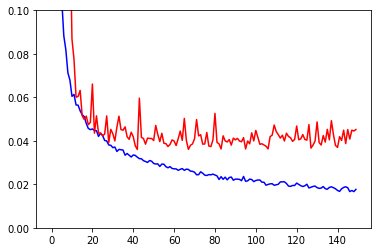

In [29]:
plt.plot(scratch_history_df['loss'], 'b') # Model loss on training data (blue)
plt.plot(scratch_history_df['val_loss'], 'r') # Model loss on validation data (red)
plt.ylim(0, 0.1)
plt.show()

In [30]:
print("Minimum validation loss with transfer learning: " + str(min(history_df['val_loss'])))
print("Minimum validation loss when trained from scratch: " + str(min(scratch_history_df['val_loss'])))

Minimum validation loss with transfer learning: 0.034948909414470326
Minimum validation loss when trained from scratch: 0.03603272881458214


From the above plot, we can see that training the model from scratch (i.e., without pre-trained GPD weights) gives us a much greater degree of overfitting. This is when the model 'memorises' precise features of our training set at the cost of not generalising to non-training data (model loss on training data, blue, continues to decrease with more training but loss on validation data, red, hits an inflection and starts increasing).

Furthermore, the minimum validation loss achieved by the transfer learning model is lower than that achieved by the model trained from scratch.

Such diagnostics indicate that the transfer learning model is more likely to generalise to our real-world seismic data.

_Note: you will see reduced overfitting if you increase the dropout rate and reduce the learning rate, but these steps increase the minimum validation loss achieved by the model._

_Further note: the training curves presented here differ slightly from those presented in the original paper. This is likely due to differences in hardware between Google Colab and the HPC facilities used in the original study, as well as differing versions of Python libraries used. As such, exact reproduction appears to be more or less impossible, even through setting seeds._

## 9. Testing and using the finalised transfer learning model

To run our transfer learning model on new data (e.g., test data), you first need to load in the weights that achieved lowest loss on our validation data:

In [31]:
# Load weights for epoch with lowest validation loss
which_lowest = np.argmin(history_df['val_loss']) + 1
model.load_weights(path_to_new_model + 'e' + str(which_lowest) + '_box.hdf5')

Let's load in the test set used in the paper:

In [32]:
# Test data
test_hf = h5py.File(path_to_train_val + 'test.h5', 'r') # All training examples
test_p = test_hf.get('p400') # Test waveforms for P-wave arrivals in centre of waveform
test_p = np.array(test_p)
test_s = test_hf.get('s400') # Test waveforms for S-wave arrivals in centre of waveform
test_s = np.array(test_s)
test_n = test_hf.get('n400') # Test waveforms for noise (no arrivals in waveform)
test_n = np.array(test_n)
test_hf.close()

# Longer waveforms (1000 samples; e.g., to test original GPD model as sliding window) can be accessed by replacing '400' with '1000' above

# Remove mean + trend and normalise
test_p = signal.detrend(test_p, axis=1)
test_s = signal.detrend(test_s, axis=1)
test_n = signal.detrend(test_n, axis=1)
test_p = test_p / np.max(np.abs(test_p), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each waveform)
test_s = test_s / np.max(np.abs(test_s), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each waveform)
test_n = test_n / np.max(np.abs(test_n), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each waveform)

Then to run the model, simply run:

In [33]:
# Run model on test data
test_p_pred = model.predict(test_p, batch_size=100, verbose=1)
test_s_pred = model.predict(test_s, batch_size=100, verbose=1)
test_n_pred = model.predict(test_n, batch_size=100, verbose=1)

400/400 [==============================] - 0s 136us/step


Let's plot first test example:

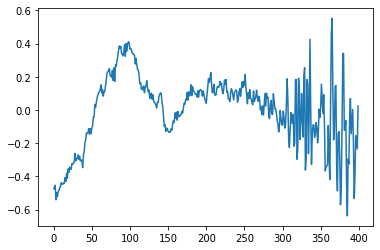

In [34]:
# Event waveform (P in centre of window)
plt.plot(test_p[1,:,2]) # Vertical component
plt.show()

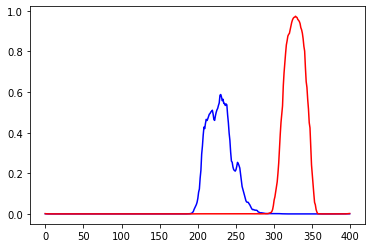

In [35]:
# Predictions for this waveform:
plt.plot(test_p_pred[1,:,0], 'b') # P-wave prediction (blue)
plt.plot(test_p_pred[1,:,1], 'r') # S-wave prediction (red)
#plt.plot(test_p_pred[0,:,2], 'g') # Noise prediction (green)
plt.show()

Does a pretty good job even on that difficult P-wave arrival. What do the GPD model predictions look like?

In [36]:
# Test data (load 1000-sample waveforms for sliding window to generate prediction for each datapoint)
# GPD model trained on 2Hz highpass data so we use that here

test_hf = h5py.File(path_to_train_val + 'test.h5', 'r') # All training examples
test_p = test_hf.get('p1000f') # Test waveforms for P-wave arrivals in centre of waveform
test_p = np.array(test_p)
test_s = test_hf.get('s1000f') # Test waveforms for S-wave arrivals in centre of waveform
test_s = np.array(test_s)
test_n = test_hf.get('n1000f') # Test waveforms for noise (no arrivals in waveform)
test_n = np.array(test_n)
test_hf.close()

In [37]:
# Define function to produce sliding windows of signal (from GPD GitHub repo https://github.com/interseismic/generalized-phase-detection/blob/master/gpd_predict.py)

def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided

In [38]:
test_example = test_p[1,:,:]
# Expand overlapping windows using sliding_window function
sliding_E = sliding_window(test_example[:,0], 400) # Slide window across first component
tr_win = np.zeros((sliding_E.shape[0], 400, 3)) # 3D array (of zeros)
tr_win[:,:,0] = sliding_E # Add to 3D array
tr_win[:,:,1] = sliding_window(test_example[:,1], 400) # Slide window across second component
tr_win[:,:,2] = sliding_window(test_example[:,2], 400) # Slide window across third component

tr_win = signal.detrend(tr_win, axis=1) # Detrend 
tr_win = tr_win / np.max(np.abs(tr_win), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each window)

# GPD model prediction
ts = gpd_model.predict(tr_win, verbose=True, batch_size=batch_size)

601/601 [==============================] - 1s 2ms/step


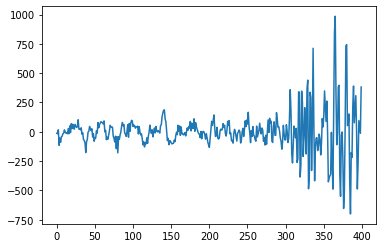

In [39]:
# Plot test example waveform again (this time with 2Hz highpass Butterworth filter)
plt.plot(test_p[1,np.arange(300, 700), 2]) # Vertical component
plt.show()

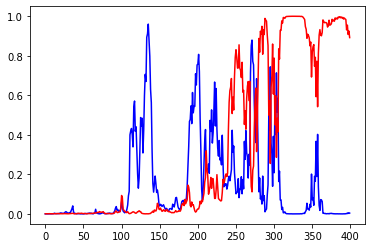

In [40]:
plt.plot(ts[np.arange(100,500), 0], 'b') # GPD P-wave prediction (blue)
plt.plot(ts[np.arange(100,500), 1], 'r') # GPD S-wave prediction (red)
#plt.plot(ts[np.arange(100,500), 2], 'g') # GPD Noise prediction (green)
plt.show()

It looks like the GPD model gives many more phase arrival triggers (both P- and S-wave) even for this very short section of data from Nabro. Perhaps this is not surprising given that it was trained on earthquake waveforms from California! However, such sensitivity will cause issue when trying to identify and associate true phase arrival times in long sections of continuous data.

For further examples of running this model on 'real world' data, see our second accompanying Colab notebook [__2_UGPD_run.ipynb:__ _Running U-GPD Transfer Learning Model on Data from Nabro Volcano_](https://github.com/sachalapins/U-GPD/blob/main/2_UGPD_run.ipynb).